In [50]:
import pandas as pd
import numpy as np
import gzip
import re
import seaborn as sns
import matplotlib.pyplot as plt
import random

P=0.05

In [3]:
#dictionary samples
table_sample=pd.read_csv("/private1/private/data/cllmap/metadata/all_deidentifier_patAndSamp_20220308.tsv",sep='\t')
# table_cllmap=pd.read_csv("/home/ls/rachelcw/projects/cllmap_pat_samp_id_map.extended.20221205.tsv",sep='\t')
# rna_id=list(table_cllmap['rna_tumor_sample_id'].dropna())
dict_sample=dict(zip(table_sample[table_sample.columns[0]],table_sample[table_sample.columns[1]]))

In [82]:
cll_data=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/cll_data.20230116.csv")
#data.drop(columns=data.columns[0], inplace=True)

groups_file_path='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/groups_file.shuffle.20230116/'

In [74]:
# # edit cll data - add dhx15 ex, rename columns, replace values # #

# master_table=pd.read_csv("/home/ls/rachelcw/projects/cllmap_rnaseq_tpms_603samps_deseqLog10_batchcorr.tsv",sep="\t")
# dhx15=master_table.loc[(master_table['Description']=='DHX15')]
# dhx15=dhx15.drop(columns=["Name"])
# dhx15.set_index('Description',inplace=True)
# dhx15_t=dhx15.T
# cll_data=cll_data.merge(dhx15_t,right_index=True,left_on='key')
# cll_data['ighv_mut'] = cll_data['ighv_mut'].replace(['unmutated', 'mutated'], ['U-CLL', 'M-CLL'])
# cll_data=cll_data.rename(columns={'SUGP1_ex':'SUGP1'})

# cll_data.to_csv('/home/ls/rachelcw/projects/LEAFCUTTER/cll_data.20230116.csv')

In [32]:
# effect_sizes=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/ds.a2.20221226_effect_sizes.txt",sep="\t")
# cluster=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/ds.a2.20221226_cluster_significance.txt",sep=" ")
# print(effect_sizes.shape)
# print(cluster.shape)

In [76]:
# covariates table for DS 
covariate_table=pd.read_csv("/home/ls/rachelcw/projects/PEER/covariates_table_20230109.csv", index_col=0)

# convert binary data to labels #
# # F - M
covariate_table['F']=covariate_table['F'].replace([1,0],['F','M'])
covariate_table.drop(columns='M', inplace=True)
covariate_table.rename(columns={'F':'F/M'},inplace=True)
# # S-spain vs B-broad
covariate_table['seqcenter_Spain']=covariate_table['seqcenter_Spain'].replace([1,0],['S','B'])
covariate_table.drop(columns='seqcenter_Broad', inplace=True)
covariate_table.rename(columns={'seqcenter_Spain':'seqcenter'},inplace=True)
## LCSET
covariate_table['LCSET']=''
for col in covariate_table.filter(regex="^LCSET_").columns:
    covariate_table[col]=covariate_table[col].replace([1,0],[col,''])
    covariate_table['LCSET']= covariate_table['LCSET'] + covariate_table[col]

covariate_table=covariate_table.loc[:,~covariate_table.columns.str.startswith('LCSET_')]
covariate_table = covariate_table.mask(covariate_table=='')


In [91]:
def groups_file_gene(gene,output,shuffle=False,ighv=None):
    cll_data=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/cll_data.20230116.csv")
    if ighv in ['M-CLL','U-CLL']:
        print(ighv)
        cll_data=cll_data[cll_data['ighv_mut']==ighv]
    # Unmutated SF3B1
    data_unmut=cll_data[cll_data['SF3B1_mut']=='Unmutated SF3B1']
    #gene expression P low
    n=round(len(data_unmut)*P)
    low=np.array(data_unmut.nsmallest(n, columns=gene, keep='all')['key'])
    #gene expression P high
    high=np.array(data_unmut.nlargest(n, columns=gene, keep='all')['key'])
    samples=np.append(low,high)
    analysis=covariate_table.filter(items=samples, axis='index')
    groups_file=open(output,'w')
    if shuffle:
        labels=np.array(['low','high'])
        lables_list = np.repeat(labels,[len(low),len(high)],axis=0)
        labels_shuffle=np.random.permutation(lables_list)
        for label,sample in zip(labels_shuffle, samples):
            groups_file.writelines([sample,'\t'+label+'\t',analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
    else:
        #  create a file that specifies which samples go in each group- low vs. high 
        for sample in low:
            groups_file.writelines([sample, '\tlow\t',analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
        for sample in high:
            groups_file.writelines([sample, '\thigh\t',analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
    groups_file.close()
    
    
    

In [93]:
def groups_file_sf3b1(output,shuffle=False,ighv=None):
    cll_data=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/cll_data.20230116.csv")
    if ighv in ['M-CLL','U-CLL']:
        print(ighv)
        cll_data=cll_data[cll_data['ighv_mut']==ighv]
    # Unmutated SF3B1
    unmut_sample=np.array(cll_data[cll_data['SF3B1_mut']=='Unmutated SF3B1']['key'])
    # mutated SF3B1
    mut_sample=np.array(cll_data[cll_data['SF3B1_mut']=='Mutated SF3B1']['key'])

    samples=np.append(unmut_sample,mut_sample)
    analysis=covariate_table.filter(items=samples, axis='index')

    #  create a file that specifies which samples go in each group- unmut vs. mut 
    groups_file=open(output,'w')
    if shuffle:
        labels=np.array(['\tunmut\t','\tmut\t'])
        lables_list = np.repeat(labels,[len(unmut_sample),len(mut_sample)],axis=0)
        labels_shuffle=np.random.permutation(lables_list)
        for label,sample in zip(labels_shuffle, samples):
            groups_file.writelines([sample,label,analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
    else:
        for sample in unmut_sample:
            groups_file.writelines([sample, '\tunmut\t',analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
        for sample in mut_sample:
            groups_file.writelines([sample, '\tmut\t',analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
    groups_file.close()

In [84]:
# # analysis #1 : ucll+mcll - u SF3B1 - low\high SUGP1 # #
output=groups_file_path+"groups_file_s1.txt"
groups_file_gene('SUGP1',output,shuffle=True)


In [94]:
# # analysis #2 : ucll+mcll - u SF3B1 - m SF3B1 # #
output=groups_file_path+"groups_file_s2.txt"
groups_file_sf3b1(output,shuffle=True)

In [85]:
# # analysis #7 : ucll+mcll - u SF3B1 - low\high DHX15 # #
output=groups_file_path+"groups_file_s7.txt"
groups_file_gene('DHX15',output,shuffle=True)

In [92]:
# # analysis #3 : mcll - u SF3B1 - low\high SUGP1 # #
output=groups_file_path+"groups_file_s3.txt"
groups_file_gene('SUGP1',output,ighv='M-CLL',shuffle=True)


M-CLL


In [95]:
# # analysis #4 : mcll - u SF3B1 - m SF3B1 # #
output=groups_file_path+"groups_file_s4.txt"
groups_file_sf3b1(output,ighv='M-CLL',shuffle=True)

M-CLL


In [24]:
# # analysis #8 : mcll - u SF3B1 - low\high DHX15 # #
output=groups_file_path+"groups_file_s8.txt"
groups_file_gene('DHX15',output, shuffle=True,ighv='M-CLL')


/tmp/ipykernel_1935491/2223929579.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_unmut=data_mcll[cll_data['SF3B1_mut']=='Unmutated SF3B1']


In [25]:
# # analysis #5 : ucll - u SF3B1 - low\high SUGP1 # #
output=groups_file_path+"groups_file_s5.txt"
groups_file_gene('SUGP1',output, shuffle=True,ighv='U-CLL')

/tmp/ipykernel_1935491/1791933651.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_unmut=data_ucll[cll_data['SF3B1_mut']=='Unmutated SF3B1']


In [ ]:
# # analysis #6 : ucll - u SF3B1 - m SF3B1 # #
output=groups_file_path+"groups_file_s6.txt"
groups_file_sf3b1(output,ighv='U-CLL',shuffle=True)


In [27]:
# # analysis #9 : ucll - u SF3B1 - low\high DHX15 # #
output=groups_file_path+"groups_file_s9.txt"
groups_file_gene('DHX15',output, shuffle=True,ighv='U-CLL')

/tmp/ipykernel_1935491/430785336.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_unmut=data_mcll[cll_data['SF3B1_mut']=='Unmutated SF3B1']


In [26]:
#   #   #   SHUFFLE    #   #   #
import random
for i in ['1','2','3','4','5','6','7','8','9']:
    input_file='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/groups_file.analysis.20230108/groups_file_a'+i+'.txt'
    with open(input_file,'r') as source:
        data = [ (random.random(), line) for line in source ]
    data.sort()
    output_file='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/groups_file.shuffle.20230116/groups_file_s'+i+'.txt'
    with open(output_file,'w') as target:
        for _, line in data:
            target.write( line )

In [18]:
#   #   RUN LEAFCUTTER DS   #   #
# docker run -v /home/ls/rachelcw/projects/LEAFCUTTER/:/data --rm garrettjenkinson/ubuntu18leafcutter:v0.2.9.1 Rscript /leafcutter/scripts/leafcutter_ds.R /data/lc_20230108/lc_20230108_perind_numers.counts.gz /data/DS/DS.five_percent/groups_file.analysis.20230108/groups_file_a2.txt -o /data/DS/DS.five_percent/ds.a2.20230108 -p 12
# docker run -v /home/ls/rachelcw/projects/LEAFCUTTER/:/data --rm garrettjenkinson/ubuntu18leafcutter:v0.2.9.1 Rscript /leafcutter/scripts/leafcutter_ds.R /data/lc_20221211/lc_20221211_perind_numers.counts.gz /data/DS/DS.five_percent/shuffle_groups_file/groups_file_s6.txt -o /data/DS/DS.five_percent/ds.s6.20221227 -p 6


In [8]:
#   #   DS result anf filtering    #   #
FDR = 0.05

for i in ['7']:
    input_path='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/shuffle.20230116/ds.s'+i+'.20230116'
    cluster_sig= pd.read_table(input_path+'_cluster_significance.txt',sep='\t')
    #filter out all clusters that they arnt sugnificant <=0.05

    cluster_sig=cluster_sig[cluster_sig['p.adjust'] <= FDR]
    clusters=list(cluster_sig['cluster'].str.split(':',expand=True)[0]+'.*'+cluster_sig['cluster'].str.split(':',expand=True)[1])

    effect_sizes=pd.read_table(input_path+'_effect_sizes.txt',sep='\t')

    #   #   #   #   #   #   #   #   #   #   #   #  

    filtered_intron=[]
    intron=list(effect_sizes['intron'])
    for x in clusters:
        for y in intron:
            r = re.compile(x)
            z=r.search(y)
            if z != None:
                filtered_intron.append(z.string)


    #   #   #   #   #   #   #   #   #   #   #   #              

    effect_sizes.set_index('intron', inplace=True)
    effect_sizes=effect_sizes.filter(items=filtered_intron,axis='index')

    #   #   #   #   #   #   #   #   #   #   #   #   
    output_path='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/shuffle.20230116/filtered.s' + i + '.20230116'
    print(output_path)

    cluster_sig.to_csv(output_path+'_cluster_significance.txt', sep=' ',index=False)
    effect_sizes.to_csv(output_path+'_effect_sizes.txt', sep=' ')



/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/shuffle.20230116/filtered.s7.20230116


In [17]:
a1=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a1.20230115_cluster_significance.txt", sep=' ')
a2=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a2.20230115_cluster_significance.txt", sep=' ')
a3=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a3.20230115_cluster_significance.txt", sep=' ')
a4=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a4.20230115_cluster_significance.txt", sep=' ')
a6=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a6.20230115_cluster_significance.txt", sep=' ')
a7=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a7.20230115_cluster_significance.txt", sep=' ')
a8=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a8.20230115_cluster_significance.txt", sep=' ')


In [40]:
FDR=0.05
plot_pa=pd.DataFrame({'analysis':['mucll-lh','mucll-mu','mucll-DHX15','mcll-lh','mcll-mu','mcll-DHX15','ucll-lh','ucll-mu','ucll-DHX15'],'p.adjust':[len(a1['p.adjust']),len(a2['p.adjust']),len(a7['p.adjust']),len(a3['p.adjust']),len(a4['p.adjust']),len(a8['p.adjust']),0,len(a6['p.adjust']),0]},)

ax=sns.barplot(plot_pa,x='analysis',y='p.adjust')
ax.bar_label(ax.containers[0])
ax.set(title=f'FDR={FDR}, HIGH\LOW={P}, date= 16/01/2023')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=6.5)


NameError: name 'a1' is not defined

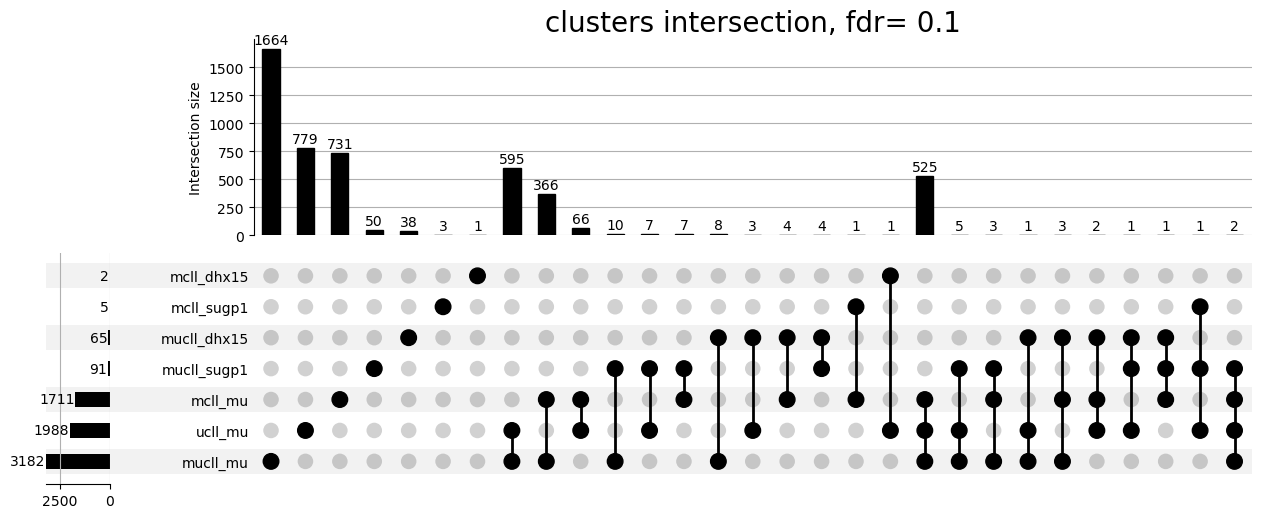

In [49]:
# # UpSet plot # #
import upsetplot as usp

mucll_sugp1=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a1.20230115_cluster_significance.txt', sep=' ')
mucll_sugp1_cluster=list(mucll_sugp1.cluster)
mucll_mu=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a2.20230115_cluster_significance.txt', sep=' ')
mucll_mu_cluster=list(mucll_mu.cluster)
mucll_dhx15=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a7.20230115_cluster_significance.txt', sep=' ')
mucll_dhx15_cluster=list(mucll_dhx15.cluster)

mcll_sugp1=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a3.20230115_cluster_significance.txt', sep=' ')
mcll_sugp1_cluster=list(mcll_sugp1.cluster)
mcll_mu=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a4.20230115_cluster_significance.txt', sep=' ')
mcll_mu_cluster=list(mcll_mu.cluster)
mcll_dhx15=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a8.20230115_cluster_significance.txt', sep=' ')
mcll_dhx15_cluster=list(mcll_dhx15.cluster)

ucll_mu=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a6.20230115_cluster_significance.txt', sep=' ')
ucll_mu_cluster=list(ucll_mu.cluster)

analysis=usp.from_contents({'mucll_sugp1':mucll_sugp1_cluster,'mucll_mu':mucll_mu_cluster,'mucll_dhx15':mucll_dhx15_cluster,'mcll_sugp1':mcll_sugp1_cluster,'mcll_mu':mcll_mu_cluster,'mcll_dhx15':mcll_dhx15_cluster,'ucll_mu':ucll_mu_cluster})
# analysis=usp.from_contents({'mucll_sugp1':mucll_sugp1_cluster,'mucll_mu':mucll_mu_cluster,'mucll_dhx15':mucll_dhx15_cluster})

upset=usp.UpSet(analysis,subset_size='count',show_counts=True)
# upset.style_subsets(present=["mucll_mu","mucll_dhx15"], facecolor="blue",label="mucll")
# upset.style_subsets(present=["mucll_mu","mucll_sugp1"], facecolor="cyan",label="mucll")
# upset.style_subsets(present=["mucll_sugp1","mcll_sugp1"], facecolor="red",label="sugp1")
upset.plot()
plt.title("clusters intersection, fdr= 0.1").set_fontsize(20)
plt.show()


In [3]:
# sugp1_lh=pd.merge(a3,a5, how='inner', on='cluster')
# #sugp1_lh=pd.merge(sugp1_lh,a5, how='inner', on='cluster')
# sugp1_lh.set_index('cluster',inplace=True)
# sf3b1_mu=pd.merge(a2,a4,how='inner',on='cluster')
# sf3b1_mu=pd.merge(sf3b1_mu,a6,how='inner',on='cluster')
# sf3b1_mu.set_index('cluster',inplace=True)
# sf3b1_mu.to_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/sf3b1_mu_cs.csv")

# effect_sizes['intron'].str.split(':',expand=True)
# cluster=effect_sizes['intron'].str.split(':',expand=True)[3]
# chr=effect_sizes['intron'].str.split(':',expand=True)[0]
# effect_sizes['cluster']=cluster
# effect_sizes['chr']=chr

# es=[]
# for value in effect_sizes['deltapsi']:
#     if abs(value)<=0.3:
#         es.append('small')
#     elif abs(value)<=0.5:
#         es.append('medium')
#     else:
#         es.append('large')

# effect_sizes['es']=es

In [ ]:
#/home/ls/rachelcw/projects/LEAFCUTTER/leafcutter/scripts/ds_plots.R -e /home/ls/rachelcw/projects/LEAFCUTTER/leafcutter/data/gencode19_exons.txt.gz /home/ls/rachelcw/projects/LEAFCUTTER/lc_20221211/lc_20221211_perind_numers.counts.gz /home/ls/rachelcw/projects/LEAFCUTTER/groups_file_peer.txt /home/ls/rachelcw/projects/LEAFCUTTER/DS/lc_ds_20221213_cluster_significance.txt -f 0.05

In [ ]:
docker run -v /home/ls/rachelcw/projects/LEAFCUTTER/:/data --rm garrettjenkinson/ubuntu18leafcutter:v0.2.9.1 Rscript /leafcutter/scripts/leafcutter_ds.R /data/lc_20230108/lc_20230108_perind_numers.counts.gz /data/DS/DS.five_percent/groups_file.shuffle.20230116/groups_file_s5.txt -o /data/DS/DS.five_percent/shuffle.20230116/ds.s5.20230116 -p 12 --init random --seed 613